In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns

In [3]:
sns.set_context('poster', font_scale=1.25)

In [4]:
sns.set_style('white')

In [5]:
%load_ext autoreload
%autoreload 2

In [10]:
from LB_D2Q9.dimensionless import opencl_dim as lb_cl
from LB_D2Q9.dimensionless import cython_dim as lb_cython
from LB_D2Q9.dimensionless import python_dim as lb_python

We now want to visualize the evolution of the flow...let's see how it goes...

In [11]:
from IPython import display

It's probably easier to specify dt and dr and the dimensions. Then get everything else from that...yeah. That way the velocity is on the scale of U ~ 0.1 or so.

In [12]:
D = 1. # meter
rho = 1. # kg/m^3
nu = 1. # Viscosity, m^2/s

pressure_grad = -10 # Pa/m

pipe_length = 3*D # meter

# initialize cylinder
cylinder_center = [pipe_length/4, D/2]
cylinder_radius = D/10

sim_cl = lb_cl.Pipe_Flow_Cylinder(diameter=D, rho=rho, viscosity=nu, pressure_grad=pressure_grad, pipe_length=pipe_length,
                             N=25, time_prefactor=1.,
                             cylinder_center=cylinder_center, cylinder_radius=cylinder_radius,
                             two_d_local_size = (32, 32), three_d_local_size = (32, 32, 1))

Characteristic L: 0.1
Characteristic T: 0.08
Reynolds number: 1.5625
inlet rho: 1.09228288
outlet rho: 1.0
omega 0.413223140496
2d global: (768, 256)
2d local: (32, 32)
3d global: (768, 256, 9)
3d local: (32, 32, 1)
The platforms detected are:
---------------------------
NVIDIA CUDA NVIDIA Corporation version: OpenCL 1.2 CUDA 7.5.23
The devices detected on platform NVIDIA CUDA are:
---------------------------
GeForce GTX TITAN Black [Type: GPU ]
Maximum clock Frequency: 980 MHz
Maximum allocable memory size: 1610 MB
Maximum work group size 1024
Maximum work item dimensions 3
Maximum work item size [1024, 1024, 64]
---------------------------
This context is associated with  1 devices


In [13]:
sim_cython = lb_cython.Pipe_Flow_Cylinder(diameter=D, rho=rho, viscosity=nu, pressure_grad=pressure_grad, pipe_length=pipe_length,
                                          cylinder_center=cylinder_center, cylinder_radius=cylinder_radius,
                                          N=25, time_prefactor=1.)

Characteristic L: 0.1
Characteristic T: 0.08
Reynolds number: 1.5625
inlet rho: 1.09228288
outlet rho: 1.0
omega 0.413223140496


In [14]:
sim_python = lb_python.Pipe_Flow_Cylinder(diameter=D, rho=rho, viscosity=nu, pressure_grad=pressure_grad, pipe_length=pipe_length,
                                          cylinder_center=cylinder_center, cylinder_radius=cylinder_radius,
                                          N=25, time_prefactor=1.)

Characteristic L: 0.1
Characteristic T: 0.08
Reynolds number: 1.5625
inlet rho: 1.09228288
outlet rho: 1.0
omega 0.413223140496


In [15]:
sim_cl.run(100)

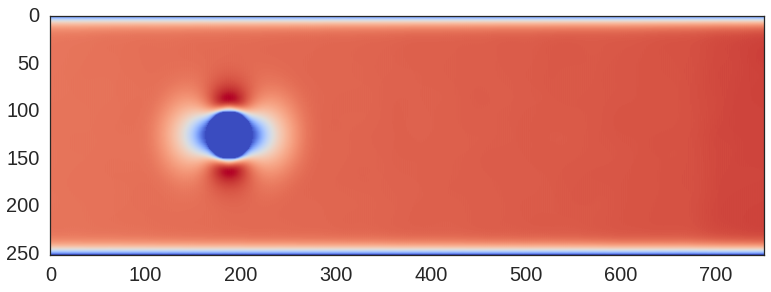

In [16]:
fields_cl = sim_cl.get_nondim_fields()
plt.imshow(fields_cl['u'].T, cmap=cm.coolwarm)

In [17]:
sim_cython.run(100)

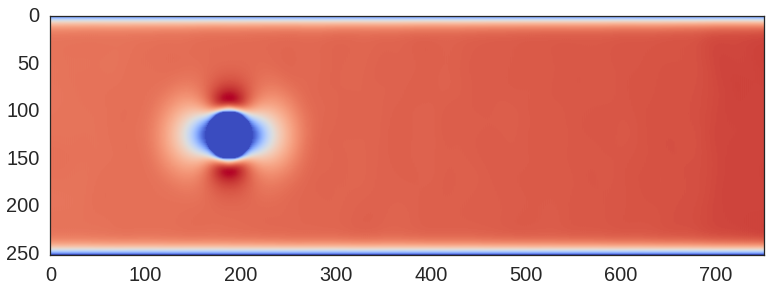

In [18]:
plt.imshow(sim_cython.u.T, cmap=cm.coolwarm)
plt.grid(False)

In [19]:
sim_python.run(100)

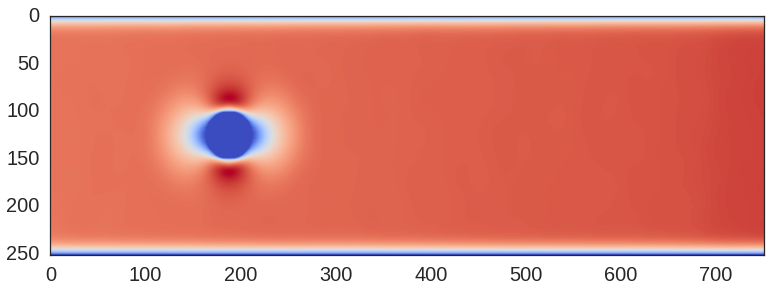

In [20]:
plt.imshow(sim_python.u.T, cmap=cm.coolwarm)
plt.grid(False)

All right! Great. We can now benchmark.

Ok I accept this. Thank god.

In [15]:
sim_cython.u.T[125, 200]

3.6730671126861125e-05

Good. We kicked a ton of butt. Let's make this into a video now.

In [11]:
total_time_to_run=100

time_per_iteration = .1 #Between frames
steps_per_iteration = int(time_per_iteration/sim.delta_t)
print 'Running for', steps_per_iteration, 'iterations between frames'
print 'Corresponds to a non-dimensional time of ' , time_per_iteration

Running for 62 iterations between frames
Corresponds to a non-dimensional time of  0.1


In [11]:
total_num_steps = int(np.ceil(total_time_to_run/time_per_iteration))

/home/bryan/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


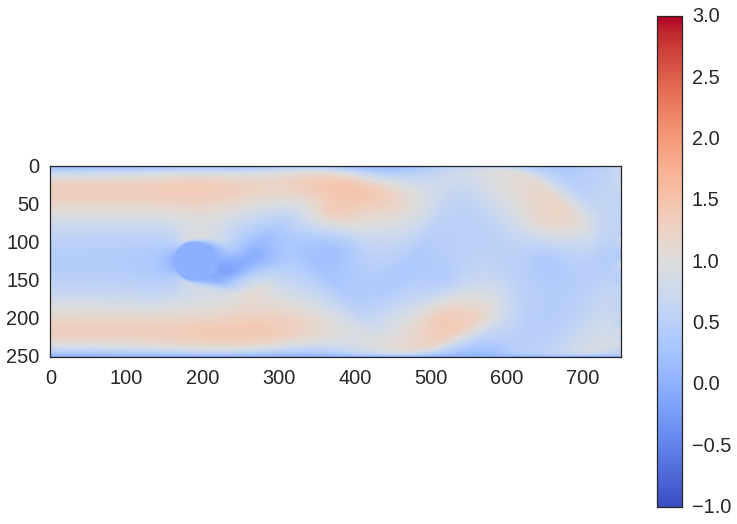

In [12]:
for i in range(total_num_steps):
    plt.clf()

    fields = sim.get_nondim_fields()
    plt.imshow(fields['u'].T, cmap=cm.coolwarm)

    plt.colorbar()
    plt.clim(-1, 3)
    
    plt.savefig('{0:04}'.format(i) + '.png', dpi=100, bbox_inches='tight')
    
    sim.run(steps_per_iteration)

Ok, this is looking more like it. Good. Let's see how developed the flow is.

IDK how to convert...but let's just fit.

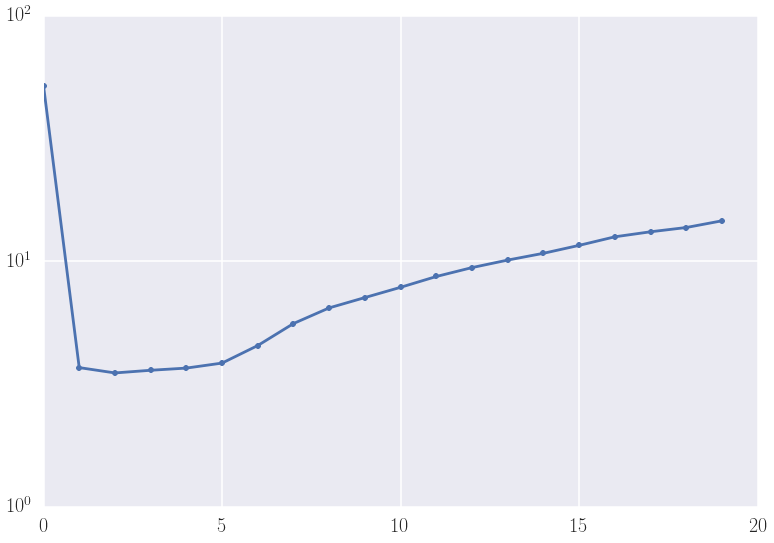

In [47]:
plt.semilogy(Ma_list, ls='-', marker='.')

Nope, it's fucked! lol.

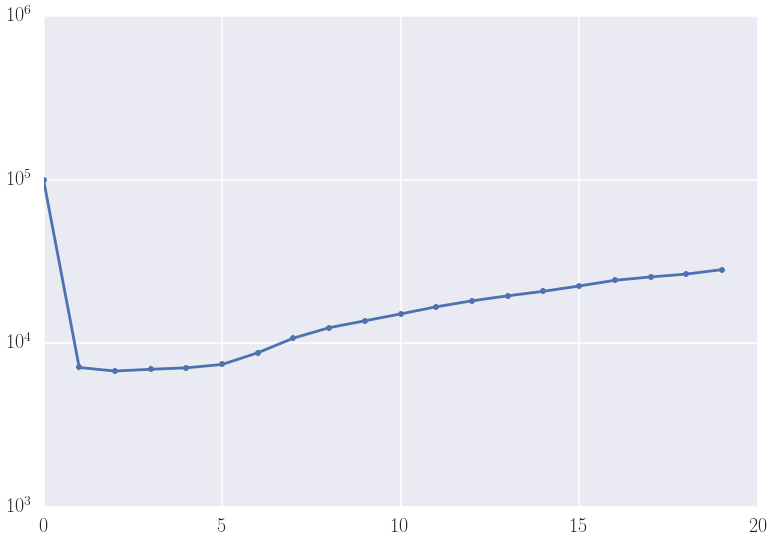

In [48]:
plt.semilogy(Re_list, ls='-', marker='.')

Looks like it still hasn't converged. But, as expected, larger pressure differences leads to larger reynolds numbers!